In [1]:
import numpy as np

J = 8
y = np.array([28.0, 8.0, -3.0, 7.0, -1.0, 1.0, 18.0, 12.0])
sigma = np.array([15.0, 10.0, 16.0, 11.0, 9.0, 11.0, 10.0, 18.0])

In [2]:
import numpyro

numpyro.enable_x64()
numpyro.set_platform("cpu")
numpyro.set_host_device_count(4)
numpyro.enable_validation()

In [3]:
import numpyro
import numpyro.distributions as dist
from numpyro.infer.reparam import LocScaleReparam

def eight_schools(J, sigma, y=None):

    mu = numpyro.sample('mu', dist.Normal(0, 5))
    tau = numpyro.sample('tau', dist.LogNormal(np.log(5), 1))
    
    with numpyro.plate('J', J):
        with numpyro.handlers.reparam(config={'theta': LocScaleReparam(centered=0)}):
            theta = numpyro.sample('theta', dist.Normal(mu, tau))
            
        numpyro.sample('obs', dist.Normal(theta, sigma), obs=y)

In [4]:
from jax import random
from numpyro.infer import MCMC, NUTS

nuts_kernel = NUTS(eight_schools)
mcmc = MCMC(nuts_kernel, num_warmup=10000, num_samples=1_000_000, num_chains=4)
mcmc.run(random.PRNGKey(0), J, sigma, y=y)

  0%|          | 0/1010000 [00:00<?, ?it/s]

  0%|          | 0/1010000 [00:00<?, ?it/s]

  0%|          | 0/1010000 [00:00<?, ?it/s]

  0%|          | 0/1010000 [00:00<?, ?it/s]

In [6]:
import arviz as az 
import matplotlib.pyplot as plt

inference_data_nuts = az.from_numpyro(mcmc)
inference_data_nuts.to_netcdf("results/inference_data_nuts.nc")

'results/inference_data_nuts.nc'

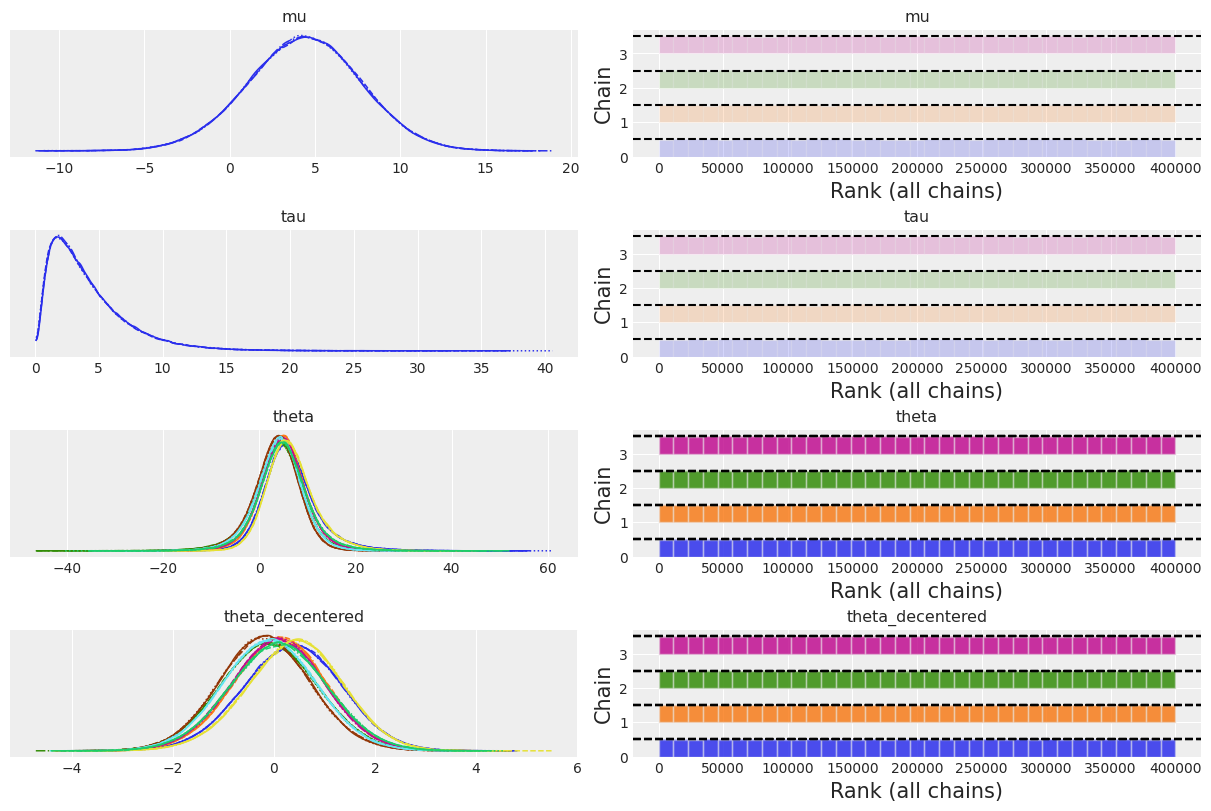

In [58]:
import arviz as az 
import matplotlib.pyplot as plt

inference_data_nuts = az.from_numpyro(mcmc)

with az.style.context("arviz-darkgrid"):
    az.plot_trace(inference_data_nuts, compact=True, kind="rank_bars");
    
plt.show()

In [82]:
import jax 
from numpyro.infer.util import unconstrain_fn

num_walkers = 100

init_values = {
        "mu": np.random.normal(loc=5, scale=0.5, size=(num_walkers,)),
        "tau": np.abs(np.random.normal(loc=1, scale=0.2, size=(num_walkers,))), 
        "theta_decentered": np.random.normal(loc=0, scale=0.5, size=(num_walkers, 8))
    }

init_values = jax.vmap(lambda x : unconstrain_fn(eight_schools, (J, sigma), dict(y=y), x))(init_values)

sample: 100%|██████████| 10000/10000 [00:03<00:00, 2750.84it/s, acc. prob=0.30]


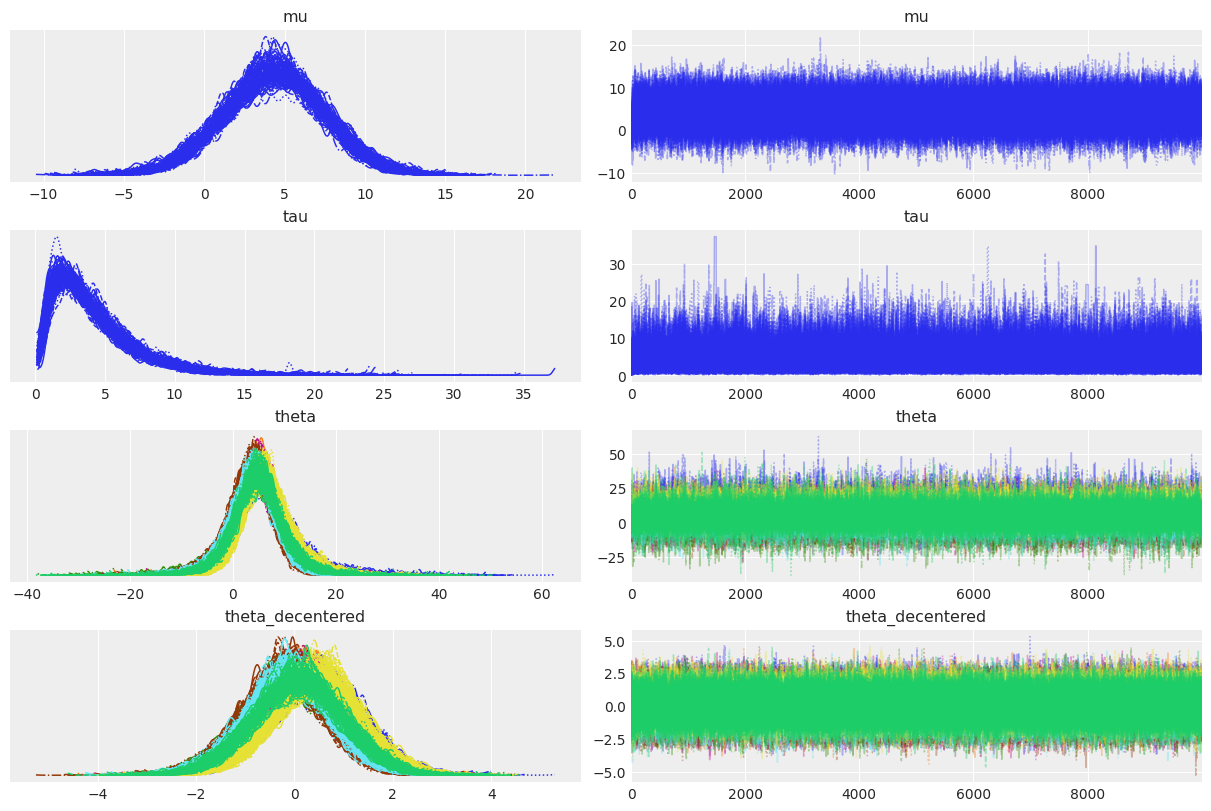

In [90]:
from numpyro.infer import AIES, ESS

aies_kernel = AIES(eight_schools)

for i in range(100):
    
    mcmc = MCMC(aies_kernel, num_warmup=0, num_samples=10_000, num_chains=num_walkers, chain_method="vectorized")
    mcmc.run(random.PRNGKey(np.random.randint(0, int(1e6))), J, sigma, y=y)
    az.from_numpyro(mcmc).to_netcdf(f"results/inference_data_aies_{i}.nc")
    
inference_data_aies = az.from_numpyro(mcmc)

with az.style.context("arviz-darkgrid"):
    az.plot_trace(inference_data_aies, compact=True)#, kind="rank_bars")
    
plt.show()

sample: 100%|██████████| 10000/10000 [00:06<00:00, 1503.51it/s]


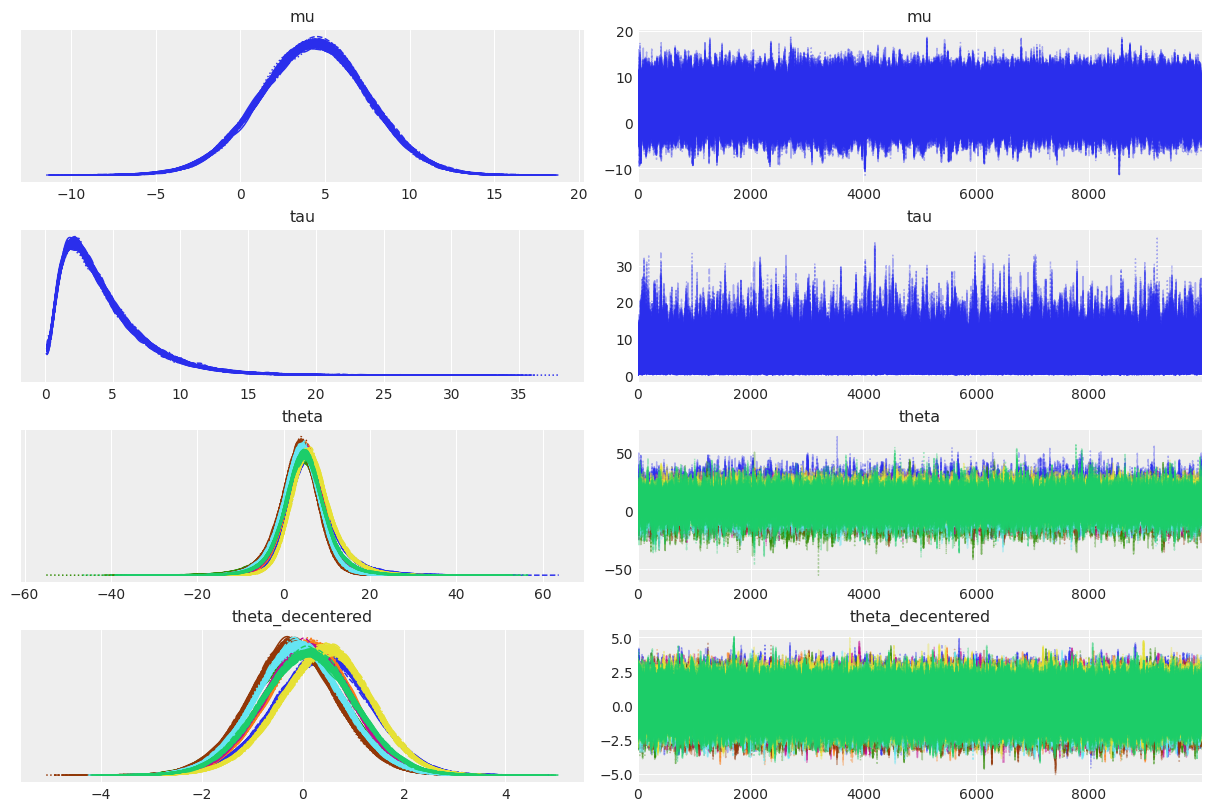

In [91]:
from numpyro.infer import ESS

ess_kernel = ESS(eight_schools)

for i in range(100):
    
    mcmc = MCMC(ess_kernel, num_warmup=0, num_samples=10_000, num_chains=num_walkers, chain_method="vectorized")
    mcmc.run(random.PRNGKey(np.random.randint(0, int(1e6))), J, sigma, y=y)
    az.from_numpyro(mcmc).to_netcdf(f"results/inference_data_ess_{i}.nc")
    
inference_data_ess = az.from_numpyro(mcmc)

with az.style.context("arviz-darkgrid"):
    az.plot_trace(inference_data_ess, compact=True)#, kind="rank_bars")
    
plt.show()

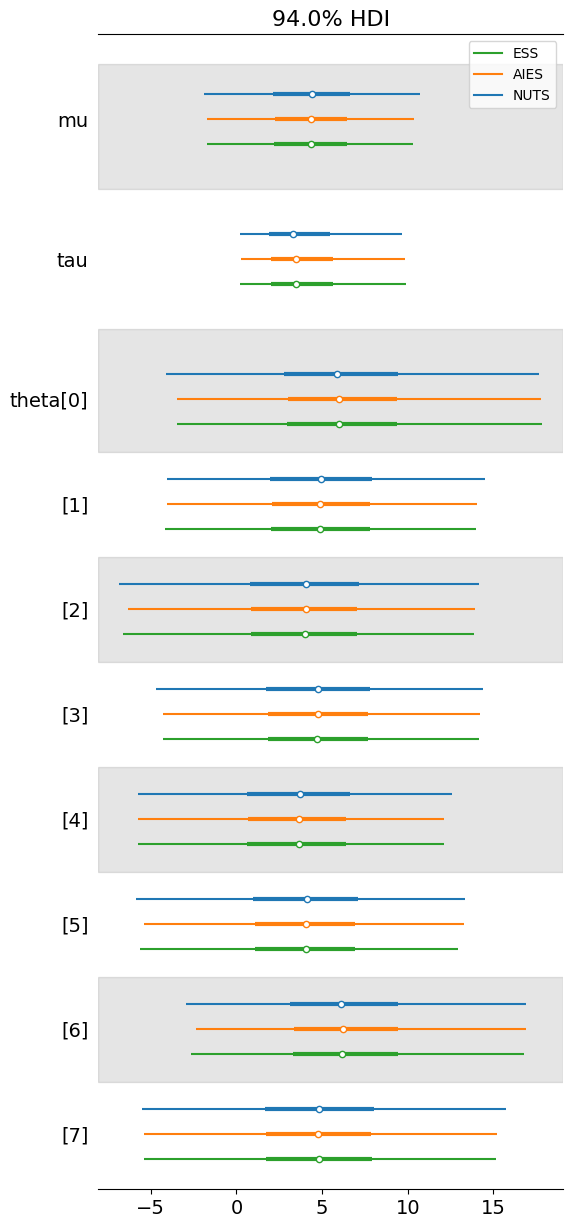

In [92]:
az.plot_forest(
    [inference_data_nuts, inference_data_aies, inference_data_ess],
    model_names=["NUTS", "AIES", "ESS"], var_names=["~theta_decentered"], 
    combined=True, kind="forestplot", ridgeplot_overlap=3)

plt.show()

In [93]:
inference_data_aies_list = [az.from_netcdf(f"results/inference_data_aies_{i}.nc") for i in range(100)]
inference_data_ess_list = [az.from_netcdf(f"results/inference_data_ess_{i}.nc") for i in range(100)]

In [102]:
from tqdm.notebook import trange

for j in trange(100): 
    
    az.concat([inference_data_aies_list[i].isel(chain=[j]) for i in range(100)], dim="chain").to_netcdf(f"results/inference_data_aies_corrected_{j}.nc")
    az.concat([inference_data_ess_list[i].isel(chain=[j]) for i in range(100)], dim="chain").to_netcdf(f"results/inference_data_ess_corrected_{j}.nc")

  0%|          | 0/100 [00:00<?, ?it/s]

In [100]:
inference_data_aies_list[0].isel(chain=[0])

Inference data with groups:
	> posterior
	> log_likelihood
	> observed_data

In [28]:
def diagnosis_along_draws(idata, subsamples=20, steps=5_000, offset=0, total_draws=100_000):
    diagnosis = np.empty((len(list(range(1, subsamples))), 2))
    #['rhat', 'ess', 'ess_sd', 'ess_bulk', 'ess_tail']

    for i in range(1, subsamples):

        local_idata = idata.sel(draw=slice(max(total_draws - steps - offset, 0),
                                         total_draws - steps - offset + (steps // subsamples) * (
                                                     i + 1)))
        diagnosis[i-1, 0] = float(az.rhat(local_idata).to_array().mean())
        diagnosis[i - 1, 1] = float(az.ess(local_idata).to_array().mean())

    return np.asarray(diagnosis)

In [34]:
x = np.arange(5000, 100_000, 5000)
results_zeus = diagnosis_along_draws(inference_data)

plt.subplot(121)
plt.loglog(x, np.asarray(results_zeus).T[0] - 1, color="blue", alpha=0.1)
plt.plot([x.min(), x.max()], [1e-2, 1e-2], color="black", linestyle="dotted", alpha=0.8)
plt.subplot(122)
plt.loglog(x, np.asarray(results_zeus).T[1], color="red", alpha=0.1)
plt.plot([x.min(), x.max()], [4e2, 4e2], color="black", linestyle="dotted", alpha=0.8)
plt.show()

In [35]:
x = np.arange(5000, 100_000, 5000)
results_zeus = diagnosis_along_draws(inference_data_zeus)

plt.subplot(121)
plt.loglog(x, np.asarray(results_zeus).T[0] - 1, color="blue", alpha=0.1)
plt.plot([x.min(), x.max()], [1e-2, 1e-2], color="black", linestyle="dotted", alpha=0.8)
plt.subplot(122)
plt.loglog(x, np.asarray(results_zeus).T[1], color="red", alpha=0.1)
plt.plot([x.min(), x.max()], [4e2, 4e2], color="black", linestyle="dotted", alpha=0.8)
plt.show()

In [37]:
x = np.arange(5000, 100_000, 5000)

for i in range(4):
    inference_data_emcee = az.from_netcdf(f"results/inference_data_emcee_{i}.nc")
    results = diagnosis_along_draws(inference_data_emcee)
    plt.subplot(121)
    plt.loglog(x, np.asarray(results).T[0] - 1, color="blue", alpha=0.1)
    plt.plot([x.min(), x.max()], [1e-2, 1e-2], color="black", linestyle="dotted", alpha=0.8)
    plt.subplot(122)
    plt.loglog(x, np.asarray(results).T[1], color="red", alpha=0.1)
    plt.plot([x.min(), x.max()], [4e2, 4e2], color="black", linestyle="dotted", alpha=0.8)
    
plt.show()